In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c
from astropy.io import fits
from pynufft import NUFFT
import finufft

In [2]:
# Defiying routes
antenna_route = '/home/seba/Desktop/alma.C34-2.cfg'
sky_image_route = '/home/seba/Downloads/cameraman(1).fits'
# Open cfg
antenna_pos = np.loadtxt(antenna_route, skiprows=3, usecols=(0, 1, 2))
# Open ffits
with fits.open(sky_image_route) as image:
    image_data = image[0].data
sky_image = image_data

[[-1.74539089e+01 -7.09608697e+02 -2.32867142e+00]
 [-5.42101315e+00 -7.23791104e+02 -2.33425052e+00]
 [ 1.59345351e+01 -7.00675748e+02 -2.32967552e+00]
 [-2.08937152e+01 -6.53559982e+02 -2.43766594e+00]
 [ 3.78261782e+01 -7.35876082e+02 -2.48474916e+00]
 [ 1.64147401e+01 -6.73573615e+02 -2.72574417e+00]
 [ 1.07398794e+01 -6.59567364e+02 -2.72626191e+00]
 [-2.06204213e+01 -6.33907342e+02 -2.52767284e+00]
 [-6.71237269e+00 -6.84951938e+02 -2.32694370e+00]
 [-5.03041107e+01 -7.11209498e+02 -2.33202477e+00]
 [-4.37591267e+01 -6.92174207e+02 -2.32987320e+00]
 [-5.94042934e+01 -6.67571740e+02 -2.13036557e+00]
 [-8.68728675e+01 -7.32262043e+02 -1.92881022e+00]
 [-7.10060176e+01 -6.55828175e+02 -2.12426034e+00]
 [-9.58997254e+01 -6.94890111e+02 -1.92773992e+00]
 [-1.03295848e+02 -7.19778698e+02 -1.93062752e+00]
 [-7.69023209e+01 -7.18172758e+02 -1.92907334e+00]
 [-2.60418616e+01 -7.26188809e+02 -2.33257505e+00]
 [-5.13338103e+01 -7.46674905e+02 -2.33210401e+00]
 [-8.04971567e+01 -7.65111831e+

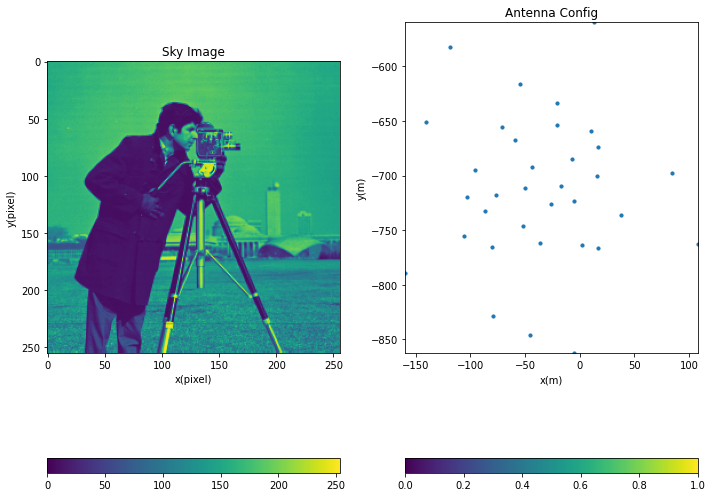

In [54]:
# Draw the entrys
fig,ax =  plt.subplots(1, 2, figsize=(10,10))
# Sky image
ax[0].set_title('Sky Image')
ax[0].set_xlabel('x(pixel)')
ax[0].set_ylabel('y(pixel)')
im_si = ax[0].imshow(sky_image, vmin=0, vmax=np.max(sky_image), aspect='equal')
# Antenna config.
ax[1].set_title('Antenna Config')
ax[1].set_xlabel('x(m)')
ax[1].set_ylabel('y(m)')
x1 = np.min(antenna_pos[:, 0])
x2 = np.max(antenna_pos[:, 0])
y1 = np.min(antenna_pos[:, 1])
y2 = np.max(antenna_pos[:, 1])
print(antenna_pos)
im_ac = ax[1].scatter(antenna_pos[:,0], antenna_pos[:,1], s=10, vmin=0, vmax=np.max(antenna_pos))
ax[1].set_xlim([x1 * 1.1, x2 * 1.1])
ax[1].set_ylim([y1 * 1.1, y2 * 1.1])
ax[1].set_aspect('equal', adjustable='box')
ax[1].axis([x1,x2,y1,y2])

fig.colorbar(im_si, ax=ax[0], orientation='horizontal')
fig.colorbar(im_ac, ax=ax[1], orientation='horizontal')
fig.tight_layout()
plt.show()

In [4]:
# Define input variables of interferometer
obs_latitude = -23.0234 # latitude of observatory
source_declination = -60 # declination of the source
ha_start = -6 # in ha from -12 to 12
ha_end = 6 # in ha from -12 to 12
sample_interval = 600 # in seconds
frequency = 90e9 # in Hz equal to 90 GHz

In [5]:
# antpos[] are XYZ coordinates in meters. XY aligned with celestial equator
# Z pointing to NCP
# antpos[1,:] -> East,  antpos[2, :] -> North, antpos[3,:] -> North Celestial Pole
# B : baselines vectors [:, 1] = x, [:, 2] = y, [:, 3] = z
# antpos[] antenna positions in meters [:, 1] = x, [:, 2] = y, [:, 3] = z

#
ant_set1 = np.repeat(antenna_pos, repeats=len(antenna_pos), axis=0)
ant_set2 = np.concatenate([antenna_pos] * len(antenna_pos), axis=0)
baseline = ant_set1 - ant_set2
# take off the [0,0,0] baseline
#print(baseline)
rows, columns = np.where(baseline == 0)
baseline = np.delete(baseline, rows, 0)
baseline = baseline.transpose()
print('the amount of baselines is ', len(baseline[0]))
print('the max baseline is ', np.max(abs(baseline)))
print('the min baseline is ', np.min(abs(baseline)))


the amount of baselines is  1122
the max baseline is  303.0391879
the min baseline is  7.92450000002276e-05


In [6]:
#
# ha_rad[] vector with hour angle samplings in radians!!!
# ha_star, ha_end in Hours (for instance -1 hora, 1 hora)
# dt sampling interval in seconds (for instance 60 seconds)
# check hour angle limits
if ha_start < -12.0:
    ha_start = -12.0
if ha_end > 12.0:
    ha_end = 12.0

# convert from degrees to radian
ha_start_rad = 15 * ha_start * np.pi / 180.0
ha_end_rad = 15 * ha_end * np.pi / 180.0
# convert from seconds to radian
dt_rad = 15 * sample_interval * np.pi / (3600 * 180)
# generate array of hour angle in rads
ha_rad = np.arange(ha_start_rad, ha_end_rad, dt_rad)
print('the amount of ha obtained is ', len(ha_rad))


the amount of ha obtained is  72


In [7]:

# obs_freq is observing frequency in Hz (continuum ??)
# telescope_lat in degrees. Example -23
# source_decl Source declination in degrees. For instance 18

# transform from degree to radian
decl_rad = source_declination * np.pi / 180
lat_rad = (-90 + obs_latitude) * np.pi / 180

# Rotate around x to rise w -Dec degrees
R2 = np.array([[1, 0, 0],
               [0, np.cos((np.pi / 2) - decl_rad), -np.sin((np.pi / 2) - decl_rad)],
               [0, np.sin((np.pi / 2) - decl_rad), np.cos((np.pi / 2) - decl_rad)]])

# Rotate around x to correct for telescope latitude
R4 = np.array([[1, 0, 0],
               [0, np.cos(lat_rad), -np.sin(lat_rad)],
               [0, np.sin(lat_rad), np.cos(lat_rad)]])


In [8]:
UVW = None #np.empty([3,3])
for k in range(0, len(ha_rad)):
    # Rotate around z to get w pointing to source
    # This matrix, R3, depends on HA, so it is computed for each
    # sampling
    # create a R3 for every HA
    R3 = np.array([[np.cos(ha_rad[k]), -np.sin(ha_rad[k]), 0],
                   [np.sin(ha_rad[k]), np.cos(ha_rad[k]), 0],
                   [0, 0, 1]])

    uvw = R4 @ R3 @ R2
    uvw = uvw.transpose()
    uvw = uvw @ baseline
    if UVW is None:
        UVW = uvw
    else:
        UVW = np.concatenate((UVW, uvw), axis=1)

# define lambda, being c the light speed constant
lambda_num = c / frequency

UVW = UVW/ lambda_num
max_uv = np.max(np.abs(UVW[:2]))
print('The number of visibilities get is ', len(UVW[0]))
print('The max uv coordinate is ', max_uv)


The number of visibilities get is  80784
The max uv coordinate is  86738.49532628797


In [9]:
# transform with fast fourier transform in 2 dimensions
fft_image = np.fft.fft2(sky_image)
fft_image = np.fft.fftshift(fft_image)

# transform with not uniform fast fourier transform in 2 dimensions
#       1st method with pynufft
NufftObj = NUFFT()                  #creation of the object
uv = UVW.transpose()                # trasposing to use in pynufft
uv = uv[:, :2]                      # only the u and v value excluding w value
uv = uv * np.pi / max_uv            # convert to radians
m, n = np.shape(sky_image)
Nd = (m, n)                         # image size
Kd = (1024, 1024)                   # k-space size
Jd = (10, 10)
NufftObj.plan(uv, Nd, Kd, Jd)
nufft_valuesv1 = NufftObj.forward(sky_image)

#       2nd method with finufft (the currently used)
u = (np.random.rand(400000, 1) * 2 -1) * np.pi
v = (np.random.rand(400000, 1) * 2 -1) * np.pi
#u = UVW[0] * np.pi / max_uv
#v = UVW[1] * np.pi / max_uv
print('max u ', np.max(u) * max_uv / np.pi)
print('min u ', np.min(u) * max_uv / np.pi)
print('max v', np.max(v) * max_uv / np.pi)
print('min v', np.min(v) * max_uv / np.pi)
maxuv = np.pi

complex_sky_image = sky_image + 1j * np.zeros_like(sky_image)
nufft_valuesv2 = finufft.nufft2d2(u.squeeze(), v.squeeze(), complex_sky_image.transpose(), eps=1e-12)


max u  86738.30431697825
min u  -86737.96154032016
max v 86737.80354721693
min v -86738.37961820935


In [10]:
# inputs of the function gridder
imagesize = max(sky_image.shape)
scheme = 0
robust = 0
# the max uv used
epsilon = 1e-5
maxuv = maxuv + epsilon
#maxuv = max_uv + epsilon
# defines deltas
deltau = -2 * maxuv / (imagesize - 1)
deltav = - deltau
#deltax = lambda_num / maxbaseline
deltax = 1 / (imagesize * deltau)
deltay = 1 / (imagesize * deltav)

print('image size is ', imagesize)
print('delta u is ', deltau, 'delta v is ', deltav)
print('delta x is ', deltax, 'delta y is ', deltay)


image size is  256
delta u is  -0.024640020812468966 delta v is  0.024640020812468966
delta x is  -0.15853273947006005 delta y is  0.15853273947006005


In [11]:
# Finding the weight values
z = len(nufft_valuesv2)
uvw_weights = np.ones(z)
pos_u_index = np.zeros(z).astype(int)
pos_v_index = np.zeros(z).astype(int)
gridded_weights = np.zeros((imagesize, imagesize))
UV = np.concatenate((u, v), axis=1) #UVW.transpose()[:,:2]
#UV = uv * max_uv / np.pi # convert from radians to lambda
print('----',UVW.shape)
# Gridding weights if ROBUST OR UNIFORM
for k in range(0, z):
    j = int(np.round(UV[k][0] / deltau) + imagesize / 2)
    i = int(np.round(UV[k][1] / deltav) + imagesize / 2)
    pos_v_index[k] = i
    pos_u_index[k] = j
    gridded_weights[i][j] += uvw_weights[k]

print(pos_u_index)
print(pos_v_index)

# Selecting a scheme for weights
for k in range(0, z):
    if scheme == 0:
        uvw_weights[k] = uvw_weights[k]
    elif scheme == 1:
        uvw_weights[k] /= gridded_weights[pos_v_index[k]][pos_u_index[k]]
    elif scheme == 2:
        uvw_weights[k] *= np.sqrt(UV[k][0] ** 2 + UV[k][1] ** 2)
    else:
        average_weights = np.sum(gridded_weights ** 2) / np.sum(uvw_weights)
        f2 = (5.0 * np.power(10.0, -robust)) ** 2 / average_weights
        uvw_weights[k] /= (1.0 + gridded_weights[pos_v_index[k]][pos_u_index[k]] * f2)


---- (3, 80784)
[177 192 194 ...  22 129  53]
[ 68  95 176 ...  18 189 111]


In [12]:
# Gridding visibilities and weights with a scheme
gridded_weights = np.zeros((imagesize, imagesize))
gridded_Vo = np.zeros((imagesize, imagesize)) + 1.0j * np.zeros((imagesize, imagesize))

for k in range(0, z):
    j = int(np.round(UV[k][0] / deltau) + imagesize / 2)
    i = int(np.round(UV[k][1] / deltav) + imagesize / 2)
    gridded_weights[i][j] += uvw_weights[k]
    gridded_Vo[i][j] += uvw_weights[k] * nufft_valuesv2[k]

# Check rows and columns where gridded weights are greater than 1
rows, columns = np.where(gridded_weights > 0)
# Divide the gridded visibilities by the gridded weights
gridded_Vo[rows, columns] /= gridded_weights[rows, columns]


In [13]:
# get dirty image with the inverse fft in 2d
dirty_image = np.fft.ifftshift(gridded_Vo)
dirty_image = np.fft.ifft2(dirty_image)
dirty_image = np.fft.fftshift(dirty_image)

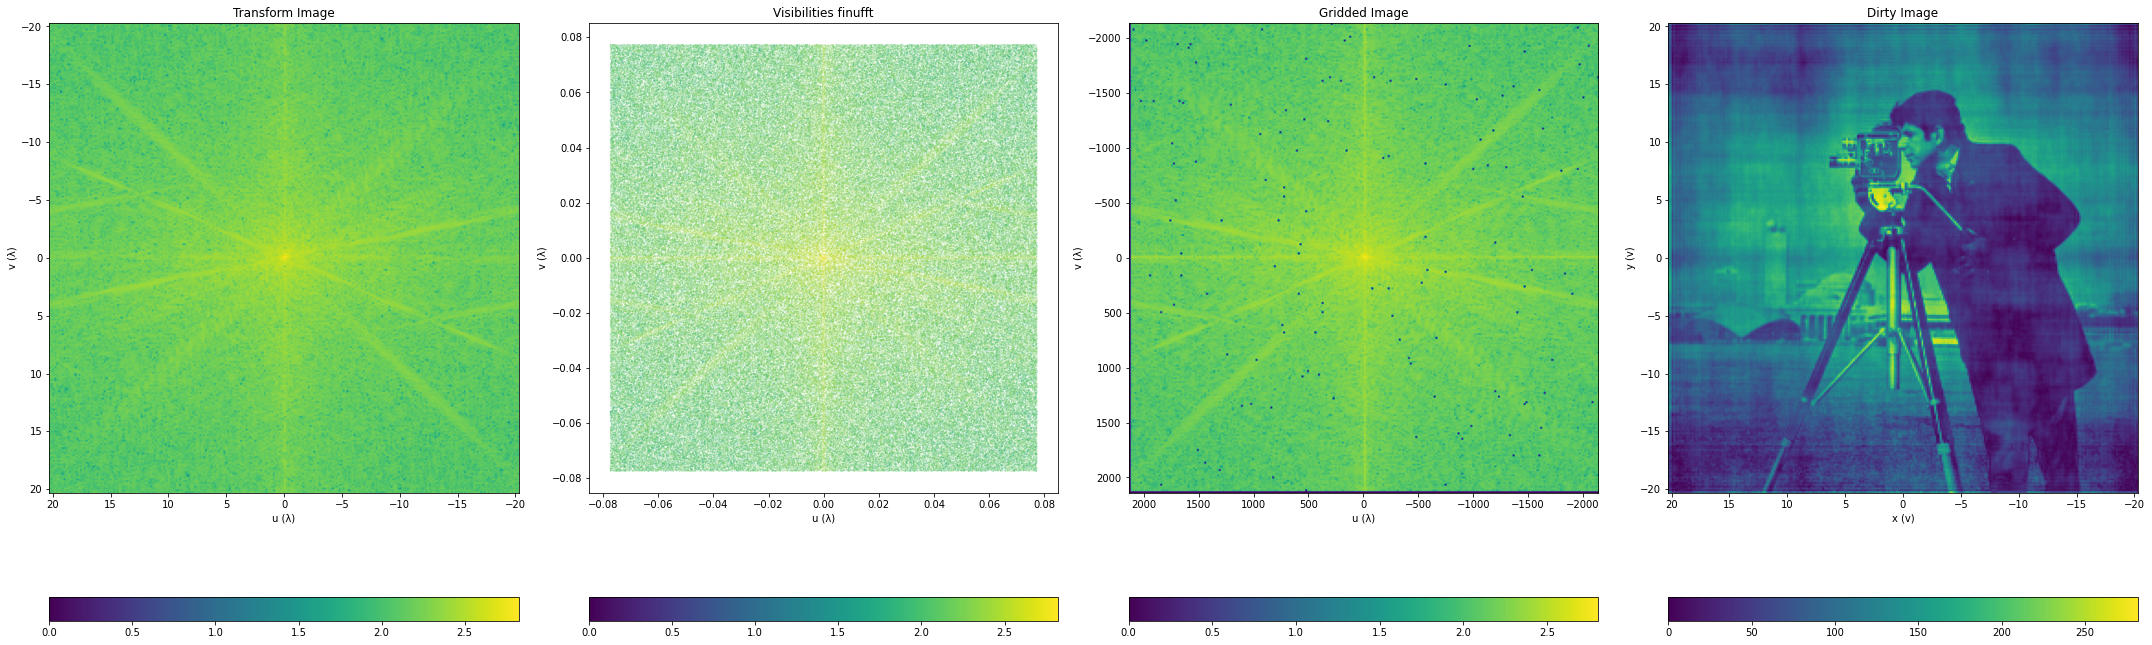

In [15]:
# create the subplots
fig,ax =  plt.subplots(1, 4, figsize=(30,10))
# transform the complex values
fft_image = np.log(abs(fft_image) + 1)
nufft_valuesv1 = np.log(abs(nufft_valuesv1) + 1)
nufft_valuesv2 = np.log(abs(nufft_valuesv2) + 1)
gridded_Vo = np.log(abs(gridded_Vo) + 1)
dirty_image = abs(dirty_image)

# fast fourier transform image
ax[0].set_title('Transform Image')
ax[0].set_xlabel('u (λ)')
ax[0].set_ylabel('v (λ)')
limit_hor = deltax * len(fft_image[0]) / 2
limit_vert = deltay * len(fft_image) / 2
im_fft = ax[0].imshow(fft_image, aspect='equal', vmin=0, vmax=np.max(fft_image), extent=[-limit_hor, limit_hor, limit_vert, -limit_vert], origin='lower')
# not uniform fast fourier transform image
ax[1].set_title('Visibilities finufft')
ax[1].set_xlabel('u (λ)')
ax[1].set_ylabel('v (λ)')
im_nufft2 = ax[1].scatter(u * deltau, v * deltav, s=0.01, c=nufft_valuesv2, vmin=0, vmax=np.max(nufft_valuesv2))
ax[1].set_aspect('equal')
# gridded image
ax[2].set_title('Gridded Image')
ax[2].set_xlabel('u (λ)')
ax[2].set_ylabel('v (λ)')
limit_hor = deltau * max_uv
limit_vert = deltau * max_uv
im_gv = ax[2].imshow(gridded_Vo, aspect='equal', vmin=0, vmax=np.max(gridded_Vo), extent=[-limit_hor, limit_hor, -limit_vert, limit_vert], origin='lower')
# dirty image
ax[3].set_title('Dirty Image')
ax[3].set_xlabel('x (v)')
ax[3].set_ylabel('y (v)')
limit_hor = deltax * len(dirty_image[0]) / 2
limit_vert = deltay * len(dirty_image) / 2
im_di = ax[3].imshow(dirty_image, aspect='equal', vmin=0, vmax=np.max(dirty_image), extent=[-limit_hor, limit_hor, -limit_vert, limit_vert], origin='lower')
# colorbars
fig.colorbar(im_fft, ax=ax[0], orientation='horizontal')
fig.colorbar(im_nufft2, ax=ax[1], orientation='horizontal')
fig.colorbar(im_gv, ax=ax[2], orientation='horizontal')
fig.colorbar(im_di, ax=ax[3], orientation='horizontal')
fig.tight_layout()
plt.show()